# Analysis of Synergy Indices
## A frequentist approach.


In [1]:
# Basic imports and setup.

import sys
import logging
from pathlib import Path

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import seaborn as sns

from neuropsymodelcomparison.dataprocessing import analysis
from neuropsymodelcomparison import plot

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

sns.set(style="darkgrid")

# Default file format for plotly figures.
pio.kaleido.scope.default_format = "pdf"


logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Get preprocessed trials data.

In [2]:
data_path = Path('../reports/block_stats.csv')
figures_path = Path('../reports/figures')

df = pd.read_csv(data_path, index_col='block_id', dtype={'exclude': bool})
df = df.loc[~df['exclude']].drop('exclude', axis='columns')
# Easier on memory and faster groupby.
df[['user', 'session', 'block', 'condition', 'task']] = df[['user', 'session', 'block', 'condition', 'task']].astype('category')

# When we view statistics by task, we want them to to be displyed in a certain order.
task_display_order = ['pre', 'df1', 'df2', 'df1|df2', 'post']
df.task.cat.reorder_categories(task_display_order, inplace=True)
condition_display_order = ['df1', 'df2', 'df1|df2']
df.condition.cat.reorder_categories(condition_display_order, inplace=True)

df.head()

,user,session,condition,block,task,count,df1 mean,df1 variance,df2 mean,df2 variance,"df1,df2 covariance",sum mean,sum variance,parallel absolute average,parallel variance,orthogonal absolute average,orthogonal variance,dV,dVz,rating
block_id,,,,,,,,,,,,,,,,,,,,
28,9,1,df1|df2,1,pre,28,57.286744,1.896588,66.294234,2.371020,-1.670264,123.580978,0.927079,1.523656,3.804069,0.552778,0.463540,1.565527,1.052467,0
29,9,1,df1|df2,2,df1|df2,29,61.341153,2.957292,61.498744,32.293062,-1.113879,122.839898,33.022596,2.300959,18.739057,2.104961,16.511298,0.126396,0.063283,1
30,9,1,df1|df2,3,post,30,59.048231,10.081573,64.725942,26.398456,-15.886674,123.774173,4.706680,2.670348,34.126689,0.787052,2.353340,1.741959,1.337122,0
31,10,1,df1|df2,1,pre,20,64.677440,14.666801,60.861312,12.463574,-12.214332,125.538753,2.701710,4.202974,25.779519,0.812044,1.350855,1.800835,1.474421,2
32,10,1,df1|df2,2,df1|df2,23,62.739136,12.693437,60.771366,4.945265,-1.208985,123.510502,15.220732,2.446032,10.028336,2.133912,7.610366,0.274166,0.137952,3


## Projection variance per direction to UCM

###  For each participant

In [4]:
df_long = analysis.wide_to_long(df, ['parallel', 'orthogonal'], suffixes='variance', j='projection')
fig_proj_line = plot.generate_lines_plot(df_long, "variance", by='user', color_col='projection', category_orders={'condition': condition_display_order}, width=1000)
fig_proj_line.show()

### Across participants

INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/line-plot-projections.pdf


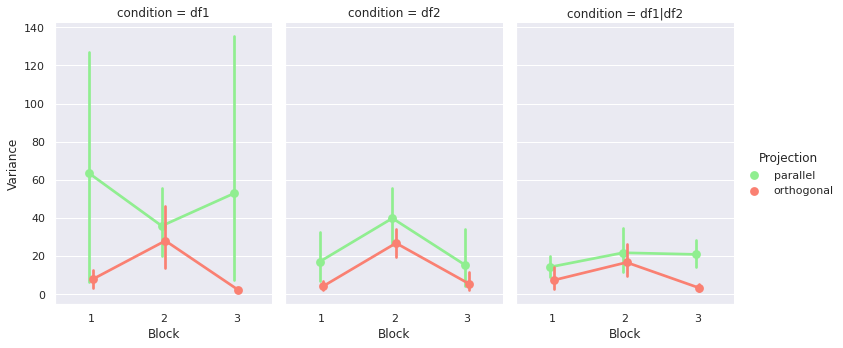

In [4]:
fig_proj_line2 = sns.catplot(x="Block", y="Variance", hue="Projection", col="condition", col_order=condition_display_order, data=df_long.rename(columns={'variance': 'Variance', 'block': 'Block', 'projection': 'Projection'}), kind="point", dodge=True, width=10, aspect=.7, palette={'parallel': 'lightgreen', 'orthogonal': 'salmon'})

fig_filepath = figures_path / 'line-plot-projections.pdf'
plt.savefig(str(fig_filepath))
logging.info(f"Written figure to {fig_filepath.resolve()}")

In [5]:
fig_proj_violin = plot.generate_violin_figure(df.rename(columns={'parallel variance': 'parallel', 'orthogonal variance': 'orthogonal'}), columns=['parallel', 'orthogonal'], ytitle='Variance', legend_title="PROJECTION", width=1000)
fig_proj_violin.show()

## Inferential Statistics
### Wilcoxon Rank Test

In [6]:
# Overall comparison.
decision, w, p = analysis.wilcoxon_rank_test(df.rename(columns={'parallel variance': 'parallel', 'orthogonal variance': 'orthogonal'}))

print(f"The overall comparison indicates that the parallel projection scores were {(not decision) * 'not '}higher than the orthogonal projection scores across conditions, Z={w}, p = {p:.5f}.")
wilcoxon_results = pd.DataFrame({'decision': decision, 'test statistic': w, 'p': p}, index=pd.MultiIndex.from_tuples([('overall', '')], names=('condition', 'task')))
# Per condition and task.
# ToDo: Correct p-values for multiple testing?
wilcoxon_results = wilcoxon_results.append(df.groupby(['condition', 'task']).apply(lambda x: analysis.wilcoxon_rank_test(x.rename(columns={'parallel variance': 'parallel', 'orthogonal variance': 'orthogonal'}))).apply(pd.Series).rename(columns={0: 'decision', 1: 'test statistic', 2: 'p'}))

wilcoxon_results

The overall comparison indicates that the parallel projection scores were higher than the orthogonal projection scores across conditions, Z=3524.0, p = 0.00000.


decision  test statistic             p
condition task                                           
overall                True          3524.0  1.416646e-09
df1       pre         False            17.0  1.093750e-01
          df1          True            19.0  4.687500e-02
          post         True            21.0  1.562500e-02
df2       pre          True            35.0  7.812500e-03
          df2          True            33.0  1.953125e-02
          post        False            27.0  1.250000e-01
df1|df2   pre          True           108.0  1.931763e-02
          df1|df2     False            95.0  8.767700e-02
          post         True           130.0  2.136230e-04

## Visual inspection of Synergy Index

INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/line-plot-dVz_by_user.pdf


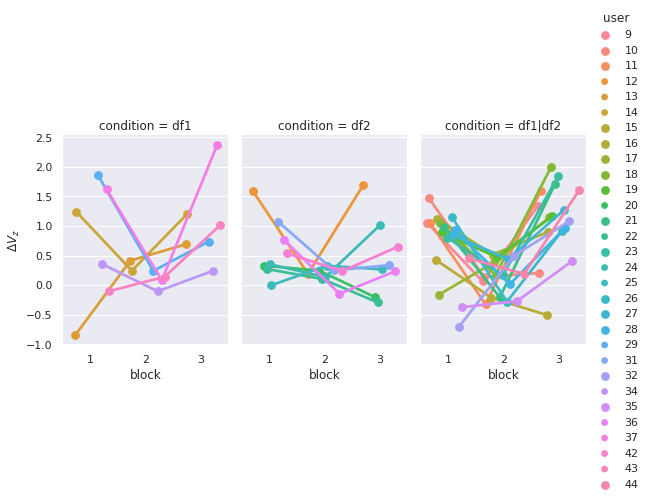

In [7]:
fig_dVz = sns.catplot(x="block", y="$\\Delta V_z$",
                      hue="user", col="condition",
                      data=df.rename(columns={'dVz': '$\\Delta V_z$'}), kind="point",
                      dodge=True,
                      height=4, aspect=.7)

fig_filepath = figures_path / 'line-plot-dVz_by_user.pdf'
plt.savefig(str(fig_filepath))
logging.info(f"Written figure to {fig_filepath.resolve()}")

INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/line-plot-dVz.pdf


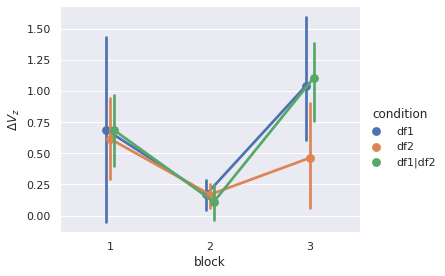

In [8]:
fig_dVz = sns.catplot(x="block", y="$\\Delta V_z$",
                      hue="condition",
                      data=df.rename(columns={'dVz': '$\\Delta V_z$'}), kind="point",
                      dodge=True,
                      height=4, aspect=1.333)

fig_filepath = figures_path / 'line-plot-dVz.pdf'
plt.savefig(str(fig_filepath))
logging.info(f"Written figure to {fig_filepath.resolve()}")

### Normality of Fisher-z-transformed Synergy Index
Make sure the tranformation worked.

In [9]:
import pingouin as pg
pg.options['round'] = 4

norm_dVz = df.groupby('task')['dVz'].apply(lambda x: pg.normality(x).iloc[0]).unstack(level=1)
norm_dVz

,W,pval,normal
task,,,
pre,0.966253,0.442354,True
df1,0.975935,0.929658,True
df2,0.85596,0.109407,True
df1|df2,0.907364,0.105527,True
post,0.985355,0.943076,True


### Mixed ANOVA


In [10]:
anova_dVz = analysis.mixed_anova_synergy_index_z(df)
anova_dVz

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,condition,0.835976,2,27,0.417988,0.967500,0.392820,NaN,0.066874,NaN,NaN,NaN,NaN
1,block,9.580924,2,54,4.790462,17.325812,0.000002,0.000002,0.390874,0.987982,True,0.987836,0.842538
2,Interaction,1.522061,4,54,0.380515,1.376221,0.254394,NaN,0.092511,NaN,NaN,NaN,NaN


There's evidence for a main effect of block on the synergy index with the effect accounting for 39% of variability (partial eta squared/np2) in the index for this sample.

_**To do: Compare effect size with other research in that domain**_

## Posthoc Testing

In [11]:
posthoc_comparisons = analysis.posthoc_ttests(df)
posthoc_comparisons

,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,-,df1|df2,df2,0.634094,0.337876,0.416093,0.355479,False,True,1.439632,13.469636,one-sided,8.640295e-02,0.475216,fdr_by,1.6,0.612630
1,condition,-,df1|df2,df1,0.634094,0.337876,0.633874,0.508192,False,True,0.000982,6.733359,one-sided,4.996224e-01,0.915974,fdr_by,0.832,0.000546
2,condition,-,df2,df1,0.416093,0.355479,0.633874,0.508192,False,True,-0.897820,8.523200,one-sided,1.969679e-01,0.541662,fdr_by,1.165,-0.478798
3,block,-,1,2,0.668008,0.671723,0.138308,0.240211,True,True,3.873672,29.000000,one-sided,2.815777e-04,0.000774,fdr_by,110.212,1.036444
4,block,-,1,3,0.668008,0.671723,0.921434,0.699630,True,True,-1.756597,29.000000,one-sided,4.477130e-02,0.082081,fdr_by,1.519,-0.364725
5,block,-,2,3,0.138308,0.240211,0.921434,0.699630,True,True,-5.967739,29.000000,one-sided,8.701285e-07,0.000005,fdr_by,2.113e+04,-1.477758
6,condition * block,df1|df2,1,2,0.686849,0.608842,0.110878,0.299517,True,True,3.201622,15.000000,one-sided,2.972036e-03,0.037835,fdr_by,16.846,1.170200
7,condition * block,df1|df2,1,3,0.686849,0.608842,1.104556,0.646230,True,True,-2.064421,15.000000,one-sided,2.835910e-02,0.145621,fdr_by,2.728,-0.648562
8,condition * block,df1|df2,2,3,0.110878,0.299517,1.104556,0.646230,True,True,-6.035259,15.000000,one-sided,1.141374e-05,0.000291,fdr_by,2115.127,-1.923221
9,condition * block,df2,1,2,0.615768,0.514115,0.168860,0.145116,True,True,2.273350,7.000000,one-sided,2.859715e-02,0.145621,fdr_by,3.436,1.118583


The synergy index in block 2 is different from blocks 1 and 3 as was expected after visual inspection of the data. The synergy index is on average smaller in block 2.

_**To do: How to interpret hedges effect size?**_

## Reshape Data for Analysis of $\Delta V_z$ in External Software.
For RM ANOVA in JASP or JAMOVI we need the data in a different form. Each block is a column. Each row is an observation of repeated measures, i.e. all $\Delta V_z$ of the same user.

In [ ]:
dVz_export = df[['user', 'condition', 'block', 'dVz']].set_index(['user', 'condition', 'block']).unstack(level='block').reset_index(level='condition')
dVz_export.columns = [f"{dvz_export.columns.names[1]}{col}" if col else "condition" for col in dvz_export.columns.get_level_values(1)]

### Save Reports

In [12]:
reports_path = Path('../reports')
# Save tables.
out_file = reports_path / 'wilcoxon-projection-results.csv'
wilcoxon_results.reset_index().to_csv(out_file, index=False)
logging.info(f"Written report to {out_file.resolve()}")

out_file = reports_path / 'normality-test-dVz.csv'
norm_dVz.to_csv(out_file)
logging.info(f"Written report to {out_file.resolve()}")

out_file = reports_path / 'anova-dVz.csv'
anova_dVz.to_csv(out_file, index=False)
logging.info(f"Written report to {out_file.resolve()}")

out_file = reports_path / 'posthoc-dVz.csv'
posthoc_comparisons.to_csv(out_file, index=False)
logging.info(f"Written report to {out_file.resolve()}")

out_file = reports_path / 'dVz-export.csv'
dVz_export.to_csv(out_file)
logging.info(f"Written report to {out_file.resolve()}")

# Save figures.
fig_filepath = figures_path / 'line-plot-projections_by_user.pdf'
fig_proj_line.write_image(str(fig_filepath))
logging.info(f"Written figure to {fig_filepath.resolve()}")

fig_filepath = figures_path / 'violin-projections.pdf'
fig_proj_violin.write_image(str(fig_filepath))
logging.info(f"Written figure to {fig_filepath.resolve()}")

INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/wilcoxon-projection-results.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/normality-test-dVz.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/anova-dVz.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/posthoc-dVz.csv
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/line-plot-projections_by_user.pdf
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/violin-projections.pdf
